<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

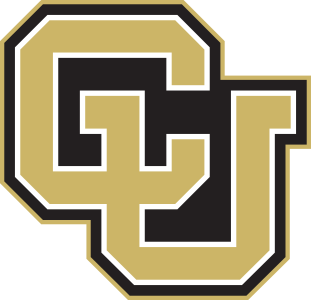

# Lecture 7, hands-on: Applying Dimensionality Reduction Techniques (R version)
*(CPBS 7602: Introduction to Big Data in the Biomedical Sciences)*

By __Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

### Notes:
* Dec 4, 2025:
   * This code should be considered preliminary as it needs testing.
   * This code was "translated" from the Python notebook `lecture07-Python-hands_on-solved.ipynb` using Claude Code v2.0.56 using model Sonnet 4.5.

# Reading Material

From the scikit-learn documentation (Python library, for reference):

* [Matrix factorization approaches](https://scikit-learn.org/dev/modules/decomposition.html) (like PCA).
* [Manifold learning](https://scikit-learn.org/dev/modules/manifold.html) (like TSNE).

For R implementations:
* PCA: `prcomp()` (base R) or `FactoMineR::PCA()`
* t-SNE: `Rtsne::Rtsne()`
* MDS: `stats::cmdscale()` or `MASS::isoMDS()`

# PCA In-Depth
(Adapted from [PyCon 2015 scikit-learn tutorial](https://github.com/jakevdp/sklearn_pycon2015) by Jake VanderPlas)

**PCA** is an extremely useful linear dimensionality reduction technique.
PCA is a very powerful unsupervised method for *dimensionality reduction* in data.
It looks for directions in the data with the most variance.

Useful to explore data, visualize data, and discern relationships.

It's easiest to visualize by examining a two-dimensional dataset:

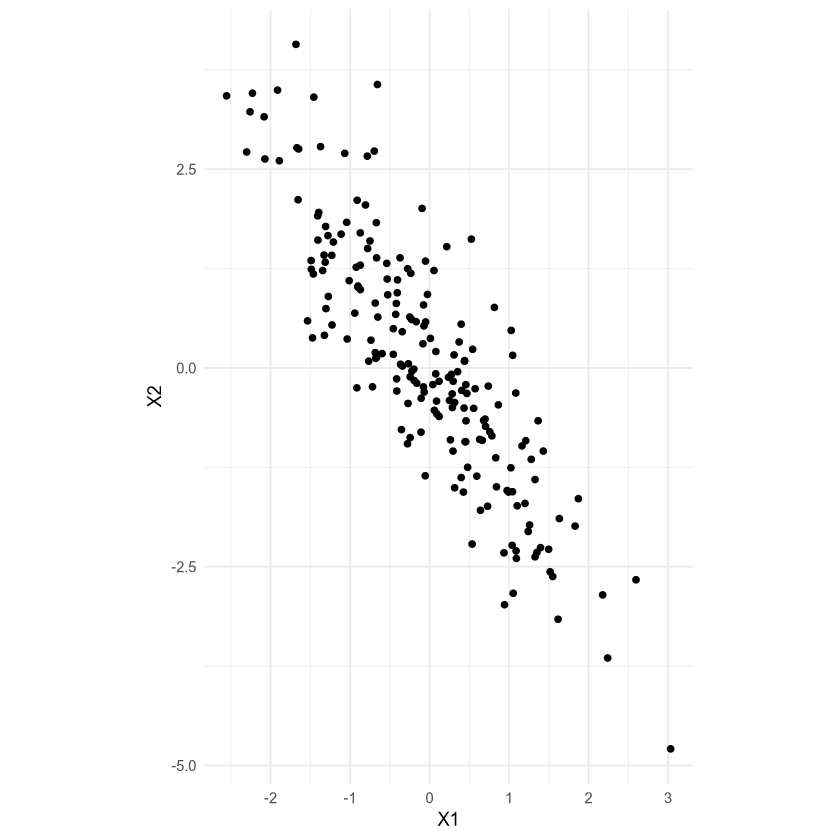

In [1]:
suppressPackageStartupMessages({
  library(ggplot2)
  library(dplyr)
  library(tidyr)
})

theme_set(theme_minimal())

set.seed(1)
# Generate 2D data with correlation
random_matrix <- matrix(rnorm(4), nrow = 2, ncol = 2)
X <- t(random_matrix %*% matrix(rnorm(400), nrow = 2, ncol = 200))

# Plot the data
plot_df <- data.frame(X1 = X[, 1], X2 = X[, 2])
ggplot(plot_df, aes(x = X1, y = X2)) +
  geom_point() +
  coord_fixed() +
  theme_minimal()

We can see that there is a definite trend in the data. PCA seeks to find the **principal axes** in the data and explain how important those axes are in describing the data distribution:

In [2]:
# Perform PCA using prcomp (standard R function)
pca <- prcomp(X, center = TRUE, scale. = FALSE)

# Display results
cat("Explained variance (standard deviations):\n")
print(pca$sdev)
cat("\nExplained variance:\n")
print(pca$sdev^2)
cat("\nExplained variance ratio:\n")
explained_var_ratio <- (pca$sdev^2) / sum(pca$sdev^2)
print(explained_var_ratio)
cat("\nPrincipal components (rotation matrix):\n")
print(pca$rotation)

Explained variance (standard deviations):
[1] 1.8041220 0.4434605

Explained variance:
[1] 3.2548563 0.1966572

Explained variance ratio:
[1] 0.94302292 0.05697708

Principal components (rotation matrix):
            PC1        PC2
[1,] -0.5227504 -0.8524858
[2,]  0.8524858 -0.5227504


Warning message in geom_segment(aes(x = 0, y = 0, xend = pca$rotation[1, 1] * 3 * :
“All aesthetics have length 1, but the data has 200 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single row.”
Warning message in geom_segment(aes(x = 0, y = 0, xend = pca$rotation[1, 2] * 3 * :
“All aesthetics have length 1, but the data has 200 rows.
ℹ Please consider using `annotate()` or provide this layer with data containing a single row.”


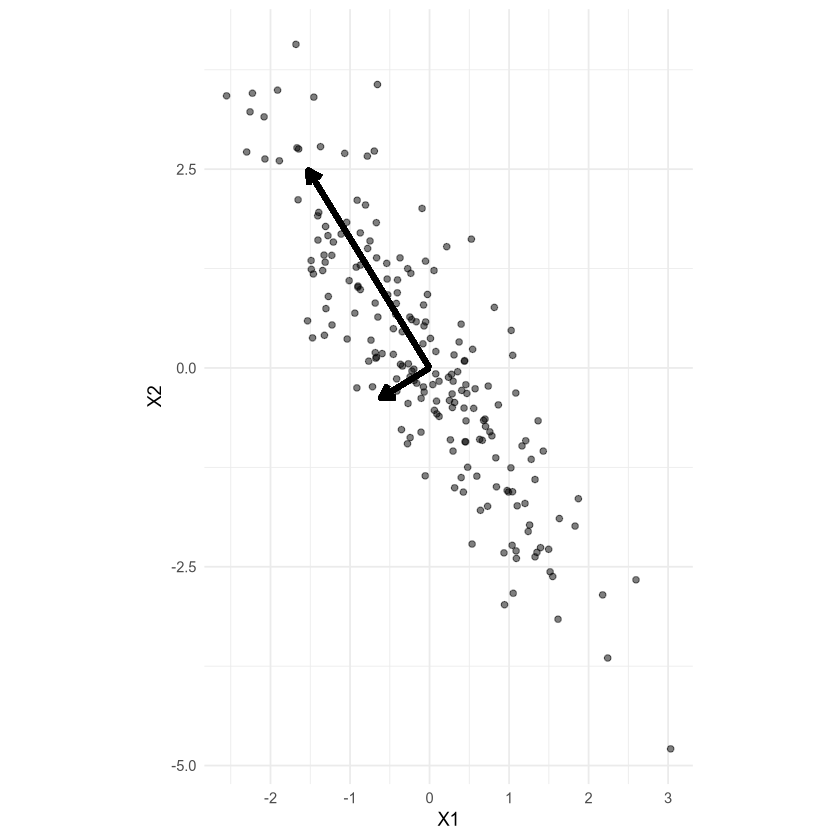

In [3]:
# Plot data with principal component vectors
ggplot(plot_df, aes(x = X1, y = X2)) +
  geom_point(alpha = 0.5) +
  # Add arrows for principal components
  geom_segment(
    aes(x = 0, y = 0,
        xend = pca$rotation[1, 1] * 3 * sqrt(explained_var_ratio[1]),
        yend = pca$rotation[2, 1] * 3 * sqrt(explained_var_ratio[1])),
    arrow = arrow(length = unit(0.3, "cm")),
    linewidth = 1.5,
    color = "black"
  ) +
  geom_segment(
    aes(x = 0, y = 0,
        xend = pca$rotation[1, 2] * 3 * sqrt(explained_var_ratio[2]),
        yend = pca$rotation[2, 2] * 3 * sqrt(explained_var_ratio[2])),
    arrow = arrow(length = unit(0.3, "cm")),
    linewidth = 1.5,
    color = "black"
  ) +
  coord_fixed() +
  theme_minimal()

Notice that one vector is longer than the other. In a sense, this tells us that that direction in the data is somehow more "important" than the other direction.
The explained variance quantifies this measure of "importance" in direction.

Another way to think of it is that the second principal component could be **completely ignored** without much loss of information! Let's see what our data looks like if we only keep 95% of the variance:

In [4]:
# Keep components that explain 95% of variance
cumsum_var <- cumsum(explained_var_ratio)
n_components <- which(cumsum_var >= 0.95)[1]

cat(sprintf("Original shape: %d x %d\n", nrow(X), ncol(X)))
cat(sprintf("Keeping %d component(s) to retain 95%% variance\n", n_components))

# Transform data (project onto principal components)
X_trans <- pca$x[, 1:n_components, drop = FALSE]
cat(sprintf("Transformed shape: %d x %d\n", nrow(X_trans), ncol(X_trans)))

Original shape: 200 x 2
Keeping 2 component(s) to retain 95% variance
Transformed shape: 200 x 2


See above that the explained variance ratio reaches 97% just with the first component.

By specifying that we want to throw away 5% of the variance, the data is now compressed by a factor of 50%! Let's see what the data looks like after this compression:

In [ ]:
# Reconstruct data from reduced components (inverse transform)
X_new <- X_trans %*% t(pca$rotation[, 1:n_components, drop = FALSE])
# Add back the center
X_new <- scale(X_new, center = -pca$center, scale = FALSE)

In [ ]:
dim(X_new)

In [ ]:
dim(X)

In [ ]:
# Plot original vs reconstructed data
plot_compare <- data.frame(
  X1 = c(X[, 1], X_new[, 1]),
  X2 = c(X[, 2], X_new[, 2]),
  Type = rep(c("Original", "Reconstructed"), each = nrow(X))
)

ggplot(plot_compare, aes(x = X1, y = X2, color = Type, alpha = Type)) +
  geom_point() +
  scale_alpha_manual(values = c("Original" = 0.2, "Reconstructed" = 0.8)) +
  scale_color_manual(values = c("Original" = "gray", "Reconstructed" = "blue")) +
  coord_fixed() +
  theme_minimal()

The light points are the original data, while the dark points are the projected version. We see that after truncating 5% of the variance of this dataset and then reprojecting it, the "most important" features of the data are maintained, and we've compressed the data by 50%.

This is the sense in which "dimensionality reduction" works: if you can approximate a data set in a lower dimension, you can often have an easier time visualizing it or fitting complicated models to the data.

## PCA on Iris Flowers

We load the iris dataset:

In [ ]:
# Load iris dataset (built into R)
data(iris)
X <- as.matrix(iris[, 1:4])
y <- as.numeric(iris$Species) - 1  # Convert to 0, 1, 2

In [ ]:
dim(X)

In [ ]:
length(y)

Now, let's apply PCA to the data:

In [ ]:
pca <- prcomp(X, center = TRUE, scale. = FALSE)
X_reduced <- pca$x[, 1:2]
cat(sprintf("Reduced dataset shape: %d x %d\n", nrow(X_reduced), ncol(X_reduced)))

In [ ]:
# Plot PCA results
plot_pca <- data.frame(
  PC1 = X_reduced[, 1],
  PC2 = X_reduced[, 2],
  Species = iris$Species
)

ggplot(plot_pca, aes(x = PC1, y = PC2, color = Species)) +
  geom_point() +
  theme_minimal() +
  labs(title = "PCA of Iris Dataset")

Let's see how features are combined (linearly) to create each principal component:

In [ ]:
cat("Meaning of the 2 components:\n\n")
feature_names <- colnames(X)
for (i in 1:2) {
  cat(sprintf("PC #%d: ", i - 1))
  components <- pca$rotation[, i]
  terms <- sapply(1:length(components), function(j) {
    sprintf("%.3f x %s", components[j], feature_names[j])
  })
  cat(paste(terms, collapse = " + "))
  cat("\n")
}

**Question:** What does this mean?

# Non-Negative Matrix Factorization (NMF or NNMF)

From the scikit-learn documentation [here](https://scikit-learn.org/dev/modules/decomposition.html#non-negative-matrix-factorization-nmf-or-nnmf):

> NMF is an alternative approach to decomposition that assumes that the data and the components are non-negative. NMF can be plugged in instead of PCA or its variants, in the cases where the data matrix does not contain negative values.

Let's use NMF (available in the `NMF` R package) and compare the results.

In [ ]:
# NMF needs the data to be non-negative
# Scale data to [0, 1] range
X_non_negative <- apply(X, 2, function(col) {
  (col - min(col)) / (max(col) - min(col))
})

In [ ]:
dim(X_non_negative)

In [ ]:
# Perform NMF
suppressPackageStartupMessages(library(NMF))

# NMF requires data to be transposed (features x samples)
nmf_result <- nmf(t(X_non_negative), rank = 2, method = "lee", seed = 123)

# Get the W (basis) matrix - this is equivalent to sklearn's transform
# In NMF, X ≈ W * H, where W is samples x components
W <- basis(nmf_result)  # This gives us features x components
# We need samples x components, so we use coef(nmf_result) transposed
X_nmf_reduced <- t(coef(nmf_result))  # Transpose to get samples x components

In [ ]:
# The components (H matrix in NMF notation, equivalent to sklearn's components_)
H <- coef(nmf_result)
H

In [ ]:
# Plot NMF results
plot_nmf <- data.frame(
  LV1 = X_nmf_reduced[, 1],
  LV2 = X_nmf_reduced[, 2],
  Species = iris$Species
)

ggplot(plot_nmf, aes(x = LV1, y = LV2, color = Species)) +
  geom_point() +
  theme_minimal() +
  labs(title = "NMF of Iris Dataset")

In [ ]:
cat("Meaning of the 2 components:\n\n")
# The basis matrix W contains the loadings (features x components)
W <- basis(nmf_result)
for (i in 1:2) {
  cat(sprintf("LV #%d: ", i - 1))
  components <- W[, i]
  terms <- sapply(1:length(components), function(j) {
    sprintf("%.3f x %s", components[j], feature_names[j])
  })
  cat(paste(terms, collapse = " + "))
  cat("\n")
}

NMF tends to be more interpretable than PCA since it builds a representation by superimposing components without subtracting.

**Question:** What impact does a method like PLIER have in this context?

# Dataset 1

Load dataset. Feature names have the format "f[NUMBER]". Column "labels", if present, are the true labels/clusters.

In [ ]:
# load dataset
suppressPackageStartupMessages(library(readr))

data <- read_tsv(
  "https://www.dropbox.com/scl/fi/8elyky9mtq9nser82xk05/dataset01.tsv?rlkey=wlue2ejkkyen8ghdxah6yqso2&st=n9x9muq9&dl=1",
  show_col_types = FALSE
)

In [ ]:
data_labels <- data$labels
data <- data %>% select(-labels)

## Exercise 1

Apply PCA and plot the projected data.

In [ ]:
# add code

## Exercise 2

What happens if we apply KMeans on the PCA projection of this data? This is what you did in lecture 3's hands-on exercise (code below for your convenience).

Complete the code below and run it.

In [ ]:
# Change the code below to use the PCA projected data
X <- matrix(nrow = 0, ncol = 0)

In [ ]:
suppressPackageStartupMessages(library(mclust))

set.seed(0)

Ks <- 2:10
n_reps <- 10
cluster_labels <- list()
pairwise_ari <- list()
centroid_positions <- list()
stability_scores <- numeric(length(Ks))

for (i in seq_along(Ks)) {
  k <- Ks[i]
  labels_list <- list()
  centroids_list <- list()

  for (rep in 1:n_reps) {
    # Perform k-means clustering
    km <- kmeans(X, centers = k, nstart = 1)
    labels_list[[rep]] <- km$cluster
    centroids_list[[rep]] <- km$centers
  }

  cluster_labels[[i]] <- labels_list
  centroid_positions[[as.character(k)]] <- centroids_list

  # Compute pairwise adjusted Rand index (ARI) for stability
  ari_values <- numeric()
  for (j in 1:(n_reps - 1)) {
    for (l in (j + 1):n_reps) {
      ari_val <- adjustedRandIndex(labels_list[[j]], labels_list[[l]])
      ari_values <- c(ari_values, ari_val)
    }
  }

  pairwise_ari[[i]] <- ari_values
  stability_scores[i] <- mean(ari_values)
}

# Plot stability scores
plot_stability <- data.frame(K = Ks, Stability = stability_scores)
ggplot(plot_stability, aes(x = K, y = Stability)) +
  geom_line() +
  geom_point(size = 3) +
  labs(x = "Number of Clusters (K)", y = "Stability Score") +
  theme_minimal()

**Question:** how does this compare with your solution from the lecture03's hands-on exercise?

## Exercise 3

What do the principal components mean? How are original features combined by PCA?

In [ ]:
# add code

## Exercise 4: Incremental PCA

From the scikit-learn documentation:

> Incremental principal component analysis (IPCA) is typically used as a replacement for principal component analysis (PCA) when the dataset to be decomposed is too large to fit in memory.

In R, we can simulate incremental PCA by processing data in batches. For this small dataset, we'll demonstrate the concept even though it's not necessary.

In [ ]:
# add code

# Dataset 2

In [ ]:
# Generate circles dataset (similar to sklearn's make_circles)
# Using reticulate to access sklearn's dataset generator
suppressPackageStartupMessages(library(reticulate))
use_condaenv("cu-cpbs-7602", required = TRUE)

sklearn_datasets <- import("sklearn.datasets")
circles_result <- sklearn_datasets$make_circles(
  n_samples = 1000L,
  factor = 0.3,
  noise = 0.05,
  random_state = 0L
)

data <- circles_result[[1]]
data_labels <- circles_result[[2]]

In [ ]:
plot_circles <- data.frame(X1 = data[, 1], X2 = data[, 2], labels = as.factor(data_labels))
ggplot(plot_circles, aes(x = X1, y = X2, color = labels)) +
  geom_point() +
  theme_minimal()

## Exercise 5

Apply PCA and plot the projected data.

In [ ]:
# add code

**Question:** What is going to happen if we apply Logistic Regression to predict the labels in the PCA projection? Is it going to help us?

In [ ]:
# add code

## Exercise 6

**Question:** Would MDS or TSNE help us in the previous prediction problem with Logistic Regression?

In [ ]:
# add code

## Exercise 7: Kernel PCA

**Question:** Would KernelPCA help us in the previous prediction problem with Logistic Regression?

*Tip:* In R, we can use the `kernlab` package which provides kernel PCA. Try a larger `kpar` value (similar to `gamma` in sklearn).

In [ ]:
# add code

# Dataset 3: Handwritten Digits
(Adapted from scikit-learn guide [here](https://scikit-learn.org/dev/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py))

Load the digits dataset and plot some examples:

In [ ]:
# Load digits dataset from sklearn
sklearn_datasets <- import("sklearn.datasets")
digits <- sklearn_datasets$load_digits(n_class = 6L)
X <- digits$data
y <- digits$target
n_samples <- nrow(X)
n_features <- ncol(X)

In [ ]:
# Plot some examples of the digits
par(mfrow = c(10, 10), mar = c(0, 0, 0, 0))
for (i in 1:100) {
  digit_matrix <- matrix(X[i, ], nrow = 8, ncol = 8, byrow = TRUE)
  image(t(digit_matrix[8:1, ]), col = gray.colors(256), axes = FALSE)
}

This is a helper function to visualize results:

In [ ]:
# Helper function to plot embedding
plot_embedding <- function(X_embedded, title) {
  # Scale to [0, 1] range
  X_scaled <- apply(X_embedded, 2, function(col) {
    (col - min(col)) / (max(col) - min(col))
  })

  # Create plot
  plot_df <- data.frame(
    X1 = X_scaled[, 1],
    X2 = X_scaled[, 2],
    digit = as.factor(y)
  )

  p <- ggplot(plot_df, aes(x = X1, y = X2, color = digit)) +
    geom_text(aes(label = digit), size = 3, alpha = 0.6) +
    labs(title = title) +
    theme_void() +
    theme(legend.position = "none")

  print(p)
}

## Exercise 8

Apply PCA, MDS, and TSNE to this data: `X` and `y`. Which one seems to do better?

In [ ]:
# add code